In [1]:
import numpy as np
import pandas as pd
import math

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
colab_path = 'ScadaData.txt'
local_path = 'C:\\Users\\hanna\\Desktop\\data\\ScadaData.txt'

scada_data = pd.read_csv(local_path, delimiter='\t',  parse_dates=True)
scada_data['dtTimeStamp'] = pd.to_datetime(scada_data['dtTimeStamp'])

average_mean_wind_speeds = scada_data[['dtTimeStamp','WindSpeedMean', 'intObjectId']].groupby('dtTimeStamp').median()[['WindSpeedMean']]
print(average_mean_wind_speeds)

                     WindSpeedMean
dtTimeStamp                       
2019-08-01 00:00:00            2.7
2019-08-01 00:10:00            2.9
2019-08-01 00:20:00            3.8
2019-08-01 00:30:00            4.3
2019-08-01 00:40:00            4.8
...                            ...
2019-09-30 23:20:00            7.0
2019-09-30 23:30:00            7.0
2019-09-30 23:40:00            6.9
2019-09-30 23:50:00            6.9
2019-10-01 00:00:00            6.8

[8785 rows x 1 columns]


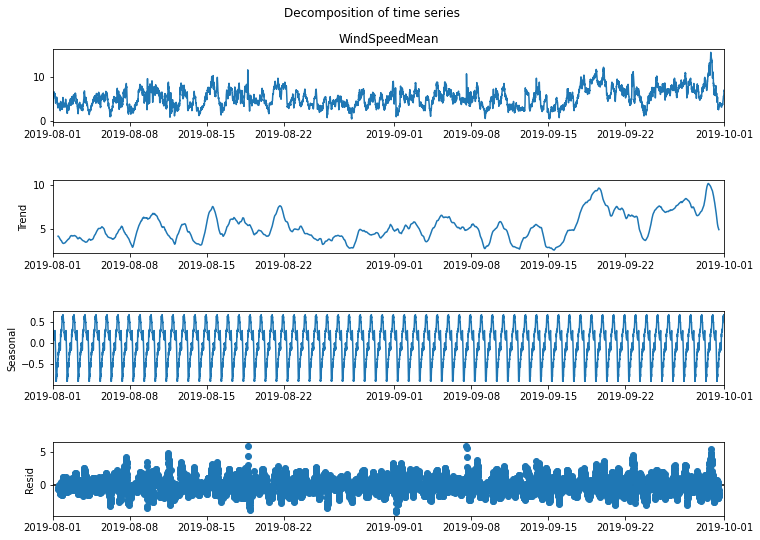

In [3]:
decomposition = sm.tsa.seasonal_decompose(average_mean_wind_speeds["WindSpeedMean"], freq=int((24*60)/10))
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of time series')
plt.show()

DatetimeIndex(['2019-08-01 08:10:00', '2019-08-02 08:10:00',
               '2019-08-03 08:10:00', '2019-08-04 08:10:00',
               '2019-08-05 08:10:00', '2019-08-06 08:10:00',
               '2019-08-07 08:10:00', '2019-08-08 08:10:00',
               '2019-08-09 08:10:00', '2019-08-10 08:10:00'],
              dtype='datetime64[ns]', name='dtTimeStamp', freq=None)


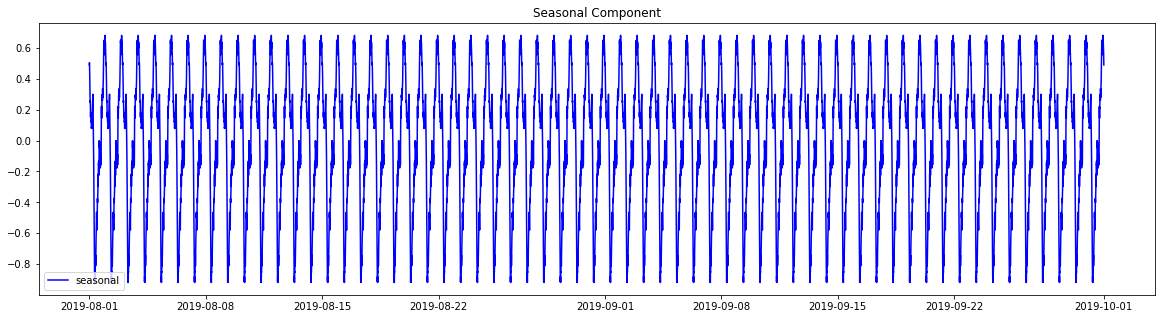

In [4]:
plt.figure(figsize=(20,5))
plt.plot(decomposition.seasonal, color='blue', label='seasonal')
plt.legend(loc='best')
plt.title('Seasonal Component')

# daily seasonality
print(decomposition.seasonal[decomposition.seasonal == decomposition.seasonal.min()].index[0:10])

In [8]:
test_data = average_mean_wind_speeds.loc['2019-08-23': '2019-10-01']
train_data = average_mean_wind_speeds.loc[: '2019-09-22']
test_data.head()

,WindSpeedMean
dtTimeStamp,
2019-08-23 00:00:00,4.2
2019-08-23 00:10:00,4.3
2019-08-23 00:20:00,5.0
2019-08-23 00:30:00,5.1
2019-08-23 00:40:00,5.1


In [ ]:
# define model configuration
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, 144)
# define model
best_model = sm.tsa.statespace.SARIMAX(train_data,
                                      order=my_order,
                                      seasonal_order=my_seasonal_order,
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit()
print('done')

In [30]:
pred_dynamic = best_results.get_forecast(steps=144, alpha=0.05)
pred_dynamic_ci = pred_dynamic.conf_int()

In [18]:
predicted = pred_dynamic.predicted_mean
truth = test_data['2019-08-09':].WindSpeedMean

print(predicted)
#print(truth)

2019-08-09 00:00:00    7.791591
2019-08-09 00:10:00    7.928154
2019-08-09 00:20:00    7.836811
2019-08-09 00:30:00    7.612735
2019-08-09 00:40:00    7.556360
                         ...   
2019-08-09 23:10:00    8.144871
2019-08-09 23:20:00    8.225584
2019-08-09 23:30:00    8.337589
2019-08-09 23:40:00    8.356322
2019-08-09 23:50:00    8.255925
Freq: 10T, Length: 144, dtype: float64


In [19]:
mse = ((predicted - truth) ** 2).mean()
print('The Mean Squared Error of our predictions is {}'.format(round(mse, 4)))

The Mean Squared Error of our predictions is 2.5422


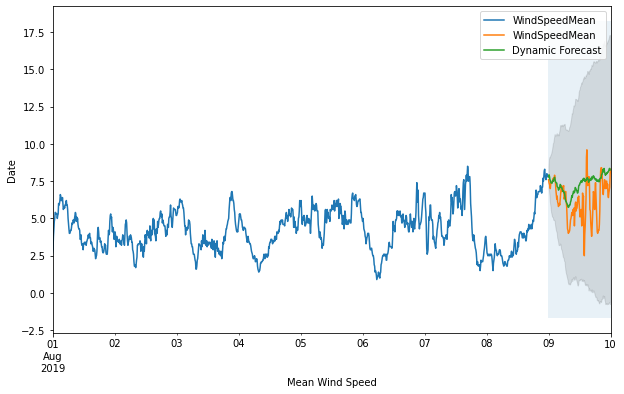

In [27]:
# Plot the actual values.
axis_plt = train_data.plot(label='train data')
test_data[0:145].plot(ax=axis_plt, label='test data', figsize=(10, 6))

# Plot the predicted values.
pred_dynamic.predicted_mean.plot(ax=axis_plt, label='Dynamic Forecast')

# Plot confidence values and fill it with some colour.
axis_plt.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=0.1)
axis_plt.fill_betweenx(axis_plt.get_ylim(), pd.to_datetime('2019-09-15'), train_data.index[-1], alpha=0.1, zorder=-1)

# Set labels.
axis_plt.set_xlabel('Mean Wind Speed')
axis_plt.set_ylabel('Date')

# Put legend on the plot at the best place it fits.
plt.legend(loc='best')